In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import astropaint as ap
from astropaint import Catalog, Canvas

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Catalog

In [2]:
catalog = Catalog("WebSky_lite")

Catalog loaded from:
/Users/siavashyasini/Dropbox/cosmology/Projects/2020/AstroPaint/astropaint/data/WebSky_lite.csv


/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Building the dataframe and updating all the parameters...

Done!


In [3]:
catalog.data.head()

,x,y,z,v_x,v_y,v_z,M_200c,redshift,D_c,lat,...,R_200c,c_200c,R_ang_200c,rho_s,R_s,v_r,v_th,v_ph,v_lat,v_lon
0,-39.47150,-1040.85400,-211.63832,-58.168945,161.24586,-122.407936,3.464257e+15,0.255665,1062.885613,-11.485313,...,2.542701,2.846457,10.326578,1.592520e+14,0.893286,-131.369896,151.601586,-64.237574,-151.601586,-64.237574
1,362.67712,237.77429,-391.54926,146.947430,-89.64066,-256.893800,3.442972e+15,0.136299,584.279154,-42.077928,...,2.804041,2.861562,18.746939,1.193344e+14,0.979899,226.889498,141.257201,-155.534493,-141.257201,-155.534493
2,-284.45068,227.38565,1309.72200,-278.443400,-156.14162,318.895080,3.403789e+15,0.333828,1359.407275,74.461525,...,2.379688,2.843241,8.026833,1.904293e+14,0.836963,339.385378,30.184651,295.823353,-30.184651,295.823353
3,212.69774,-1016.32400,-254.19002,181.956940,131.50465,-6.407848,3.396257e+15,0.257243,1069.002978,-13.755689,...,2.522784,2.851767,10.199860,1.604796e+14,0.884639,-87.296942,27.967674,205.036374,-27.967674,205.036374
4,-1378.44820,-718.89594,398.48782,96.978966,-238.50922,-108.392460,3.246793e+15,0.401340,1604.906027,14.376556,...,2.229669,2.849674,6.692805,2.218827e+14,0.782430,-3.371067,111.032445,256.321917,-111.032445,256.321917


In [4]:
catalog.size

4773576

Text(0.5, 0, 'M_200c')

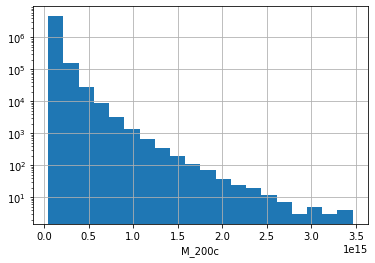

In [5]:
catalog.data.M_200c.hist(bins=20, log=True, label="M")
plt.xlabel("M_200c")

Text(0.5, 0, 'z')

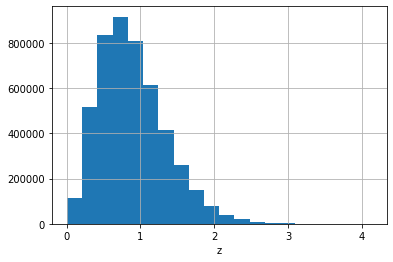

In [6]:
catalog.data.redshift.hist(bins=20)
plt.xlabel("z")

In [7]:
catalog.cut_M_200c(mass_min=2E14)

Catalog data has been modified...

Building the dataframe and updating all the parameters...

Done!


In [8]:
catalog.cut_redshift(redshift_min=0., redshift_max=0.2)

Catalog data has been modified...

Building the dataframe and updating all the parameters...

Done!


In [9]:
catalog.size

12003

# Load the Map

In [10]:
nside = 4096
canvas = Canvas(catalog, nside=nside)

You can download the map from [here](https://www.dropbox.com/s/d50lthglh683g2r/websky_lite_redshift_NFW_BG_NSIDE%3D4096.fits?dl=0) 

In [11]:
map_path = os.path.join(ap.paint_bucket.path_dir, "data", "maps", "websky_lite_redshift_NFW_BG_NSIDE=4096.fits")

In [12]:
canvas.load_map_from_file(map_path)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


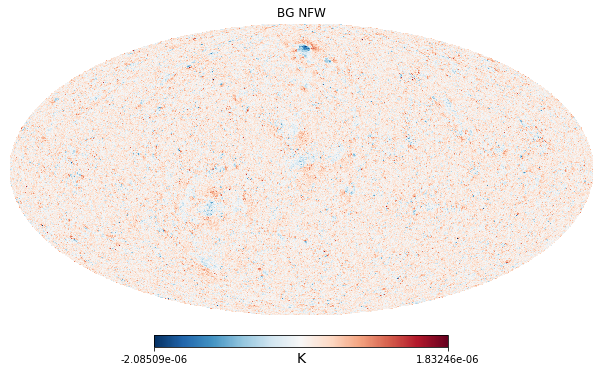

In [13]:
canvas.show_map(title="BG NFW", unit="K")

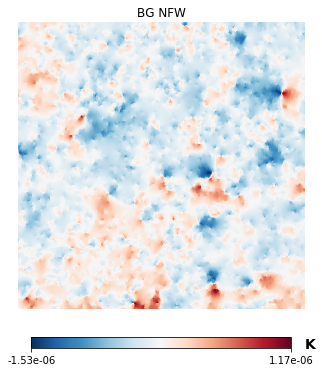

In [14]:
canvas.show_map("cartesian", title="BG NFW", unit="K",
               lonra=[0,5],
               latra=[0,5])

# Stack Cutouts

In [17]:
# define the rotation angles based on the direction of transverse velocity
# this will be passed to the ap.transform.rotate_patch function
angs = np.rad2deg(np.arctan2(catalog.data["v_th"],catalog.data["v_ph"]))
angs_df = pd.DataFrame({"angle":angs})

In [18]:
# construct the list of functions to be applied to each patch 
func_list = [ap.transform.rotate_patch, # rotate the patch according to input angle
             ap.transform.taper_patch,  # taper the edges using a Hanning window
            ]

# corresponding keyword arguments to be passed to the functions
func_kwargs_list = [angs_df, #to be passed to rotate_patch
                    {},      #to be passed to taper_patch
                    ]


In [19]:
deg_range = 2 # extent of the cutout in degrees
xpix = 200    # number of pixels on the side
dx = 60*(deg_range/xpix) # pixel resolution in arcmin
lat_range = lon_range=[-deg_range/2,deg_range/2] # extent of the cutout

# cut out patches around the first 3 halos
cutouts = canvas.cutouts(halo_list=np.arange(3),
                         xpix=xpix,
                         lon_range=lon_range,
                         lat_range=lat_range,
                         apply_func=func_list,
                         func_kwargs = func_kwargs_list,
                         )

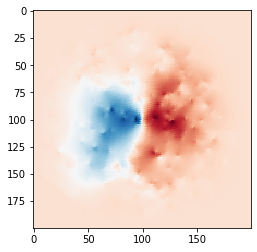

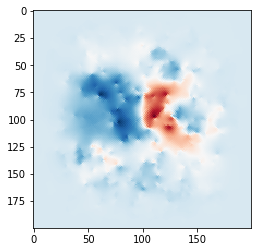

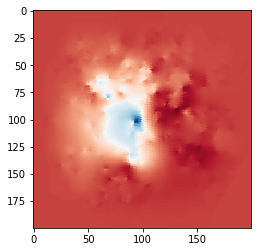

In [20]:
for cutout in cutouts:
    plt.imshow(cutout, cmap=cm.RdBu_r)
    plt.show()

In [21]:
canvas.stack_cutouts(halo_list="all", 
                     lon_range=lon_range, 
                     xpix=xpix,
                     apply_func=func_list,
                     func_kwargs=func_kwargs_list,
                     parallel=True
                     )

Stacking in parallel...
n_cpus = 4
Stacking 4 batches






Checkout the result with canvas.stack


In [22]:
stack = 1E6*canvas.stack/catalog.size #convert to uK and average over N

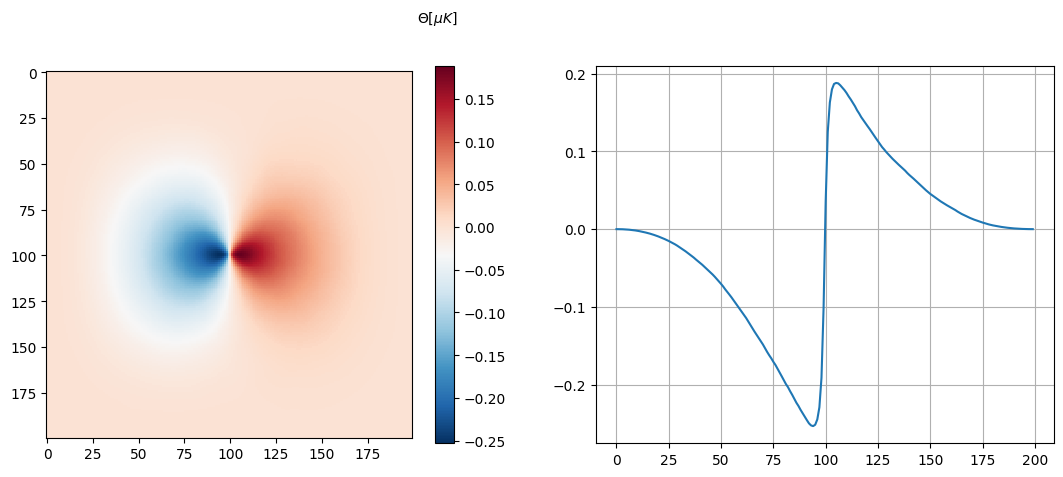

In [26]:
fig, ax = plt.subplots(1,2, figsize=(13, 5), dpi=100)

# plot the stacked BG pile
stack_plot = ax[0].imshow(stack, cmap=cm.RdBu_r)
cbar = plt.colorbar(stack_plot, ax=ax[0])
cbar.set_label(r'$\Theta [\mu K]$', labelpad=-50, y=1.15, rotation=0)

# plot a slice through the middle
ax[1].plot(stack[xpix//2])
ax[1].grid()